In [ ]:
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
np.random.seed(42)

def generate_time_series(n_points=1000, base_value=100):
    start_date = datetime(2024, 1, 1)
    timestamps = [start_date + timedelta(hours=x) for x in range(n_points)]
    
    x = np.arange(n_points)
    trend = np.zeros(n_points)
    
    changepoints = [200, 400, 700]
    slopes = [0.05, -0.03, 0.03, 0.01]  # Different slopes for each segment
    
    current_pos = 0
    for i, cp in enumerate(changepoints):
        trend[current_pos:cp] = x[current_pos:cp] * slopes[i]
        current_pos = cp
    trend[current_pos:] = x[current_pos:] * slopes[-1]
    
    hours = np.arange(n_points) % 24
    seasonality = 15 * np.sin(2 * np.pi * hours / 24) + \
                 5 * np.cos(4 * np.pi * hours / 24)  
    
    noise = np.random.normal(0, 2, n_points)
    
    values = base_value + trend + seasonality + noise
    
    df = pd.DataFrame({
        'unique_id': 'series_001',
        'ds': timestamps,
        'y': values
    })
    
    return df

df = generate_time_series()

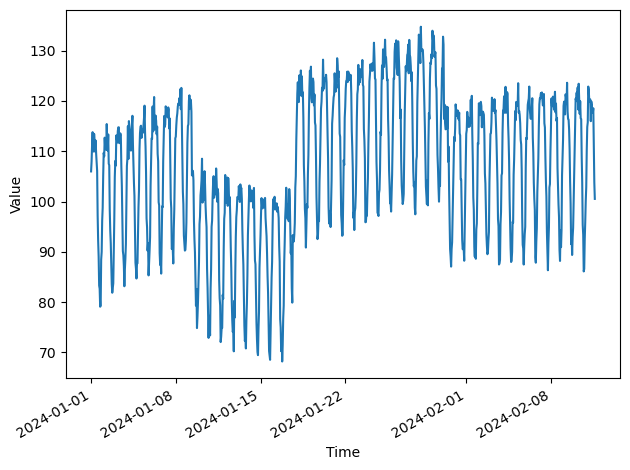

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['ds'], df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from ray import tune
from neuralforecast.auto import AutoNBEATS
from neuralforecast import NeuralForecast

In [ ]:
nbeats_config = {
   "max_steps": 100,
   "input_size": tune.choice([192, 384]),
   "basis": tune.choice(['legendre', 'polynomial', 'changepoint', 'piecewise_linear', 'linear_hat', 'spline', 'chebyshev']),
   "n_basis": 5,
   "random_seed": tune.randint(1, 10),
}

In [ ]:
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import *

model = AutoNBEATS(
    h=96,
    loss=MAE(),
    config=nbeats_config,
    search_alg=HyperOptSearch(),
    backend='ray',
    num_samples=20
)

In [ ]:
nf = NeuralForecast(models=[model], freq='M')
nf.fit(df=df, val_size=192)

2024-12-11 15:50:13,039	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-12-11 15:50:18,252	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-12-11 15:50:23,121	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-12-11 15:50:28,184	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-12-11 15:50:33,283	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s, v_num=2, train_loss_step=4.480, train_loss_epoch=4.480]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s, v_num=2, train_loss_step=4.480, train_loss_epoch=4.480]


In [ ]:
results = nf.models[0].results.get_dataframe()

config_cols = [col for col in results.columns if col.startswith('config')]
columns_to_keep = ['loss', 'train_loss'] + config_cols
existing_columns = [col for col in columns_to_keep if col in results.columns]
filtered_results = results[existing_columns]
best_runs = filtered_results.sort_values('loss', ascending=True).head(5)
best_runs

,loss,train_loss,config/max_steps,config/input_size,config/basis,config/n_basis,config/random_seed,config/h,config/loss,config/valid_loss
17,2.351707,5.403413,100,192,changepoint,5,9,96,MAE(),MAE()
11,2.351707,5.403413,100,192,changepoint,5,9,96,MAE(),MAE()
14,2.376642,5.127730,100,192,spline,5,4,96,MAE(),MAE()
9,2.391335,5.018386,100,192,piecewise_linear,5,2,96,MAE(),MAE()
13,2.499355,3.935876,100,384,changepoint,5,1,96,MAE(),MAE()


We see that allowing the choose between different basis allows the model to better adapt to different datasets. In this case, we simulated a dataset with trend changepoints and so the "changepoint basis" was selected as the best basis for this dataset.